## 目次

In [93]:
### import libraries
from warnings import filterwarnings
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.int` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')
filterwarnings(action='ignore', category=DeprecationWarning, message='`np.float` is a deprecated alias')

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math, copy, pprint

from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, accuracy_score, precision_score, recall_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier



In [2]:
df_origin = pd.read_csv('ks-projects-201801.csv')
display(df_origin.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

## 不要なデータの削除

### 説明変数の削除

In [3]:
df = copy.copy(df_origin)

# drop variables that cannot be known prior to starting projects.
df = df.drop(['pledged', 'backers', 'usd pledged', 'usd_pledged_real'], axis=1)

# drop variables unnecessary to prediction.
df = df.drop(['ID', 'goal'], axis=1)

### 目的変数の確認と、データの削除

In [4]:
df.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [5]:
# Here, consider 'canceled' as 'failed'.
df.loc[df['state']=='canceled', 'state'] = 'failed'

# drop 'undefined', 'live', and 'suspended', since these infomation cannot be known prior to starting projects.
df = df.loc[(df['state']=='failed') | (df['state']=='successful'), :]

df.state.value_counts()

failed        236498
successful    133956
Name: state, dtype: int64

## 説明変数の確認と前処理

### Overview

In [6]:
df.describe(include='all')

,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real
count,370451,370454,370454,370454,370454,370454,370454,370454,3.704540e+05
unique,367700,159,15,14,3147,369899,2,23,NaN
top,New EP/Music Development,Product Design,Film & Video,USD,2014-08-08,1970-01-01 01:00:00,failed,US,NaN
freq,15,21887,62282,289837,701,6,236498,289671,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.507638e+04
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128265e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e-02
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000e+03
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.500000e+03
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.596004e+04


### 前処理用の関数定義

In [7]:
def barplots(pdSeries):
    x = pdSeries.value_counts()
    plt.figure(figsize=(20, 5))
    sns.barplot(x.index, x.values)

def cross_heatmap(data, exp_val, tar_val):
    crossmat = pd.crosstab(data[exp_val], data[tar_val], normalize='index')
    sns.heatmap(crossmat, annot=True, fmt='.3f', cmap='Blues')


### name
frequnencyが小さすぎる。テキストデータを扱うのは今の自分には困難なので、今回は説明変数から除外する。

In [8]:
df = df.drop('name', axis=1)

### main category

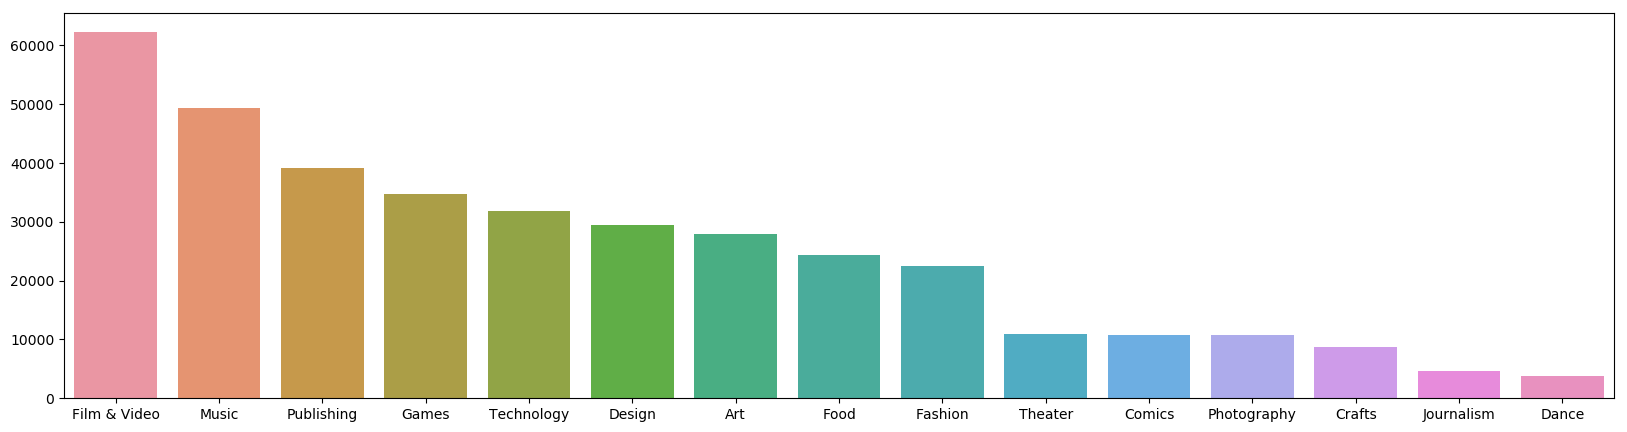

In [9]:
barplots(df['main_category'])
# 外れ値はなさそうなのでこのまま学習に利用する。

### category
Frequencyの小さい値が多すぎて、予測がそれらの値に引っ張られる可能性があると判断。
Frequencyが一定以下の値を、'main_category' カラムの値で代替する。

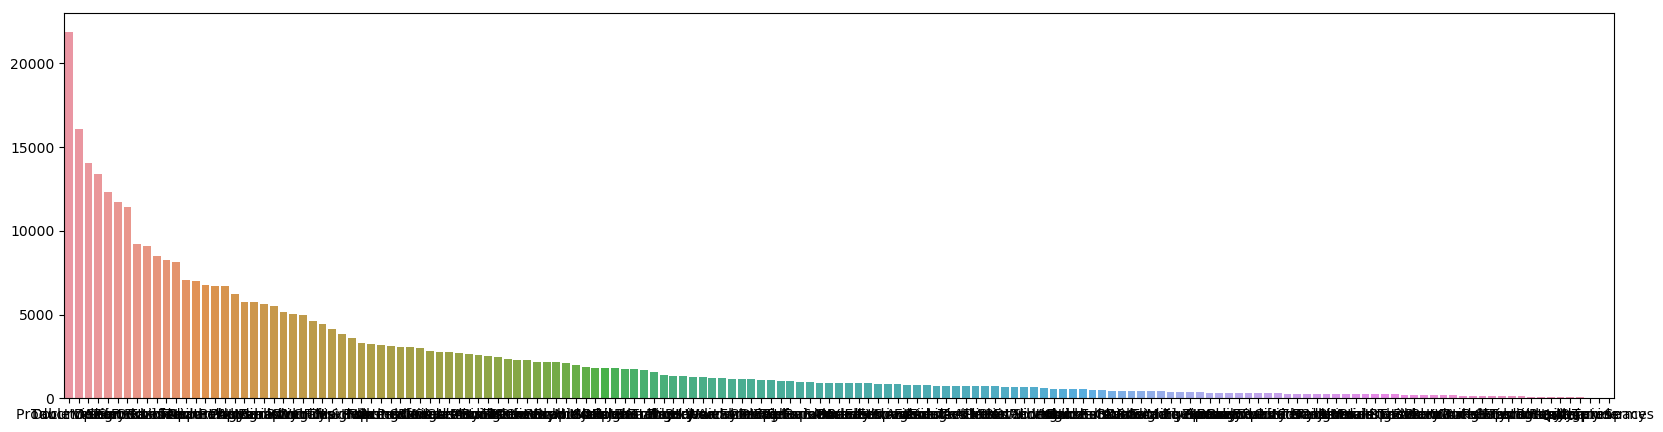

In [10]:
barplots(df['category'])

In [11]:
# Replace with 'main_category' if the frequency is too small
x = df['category'].value_counts()
thres = x.describe()['75%']
obj_to_replace = x.index[x.values < thres]
df.loc[df['category'].isin(obj_to_replace), 'category'] = df.loc[df['category'].isin(obj_to_replace), 'main_category']

(None,
 Music               25293
 Film & Video        23010
 Product Design      21887
 Food                21489
 Documentary         16065
 Art                 15681
 Publishing          14970
 Tabletop Games      14038
 Fashion             12315
 Shorts              12303
 Technology          12288
 Video Games         11691
 Theater             10850
 Comics              10720
 Photography         10675
 Fiction              9107
 Games                8994
 Crafts               8661
 Nonfiction           8259
 Design               7629
 Apparel              7030
 Rock                 6717
 Children's Books     6711
 Apps                 6239
 Webseries            5735
 Indie Rock           5639
 Narrative Film       5169
 Web                  5055
 Country & Folk       4428
 Hip-Hop              3853
 Dance                3736
 Hardware             3591
 Journalism           3453
 Pop                  3324
 Painting             3263
 Illustration         3125
 Accessories         

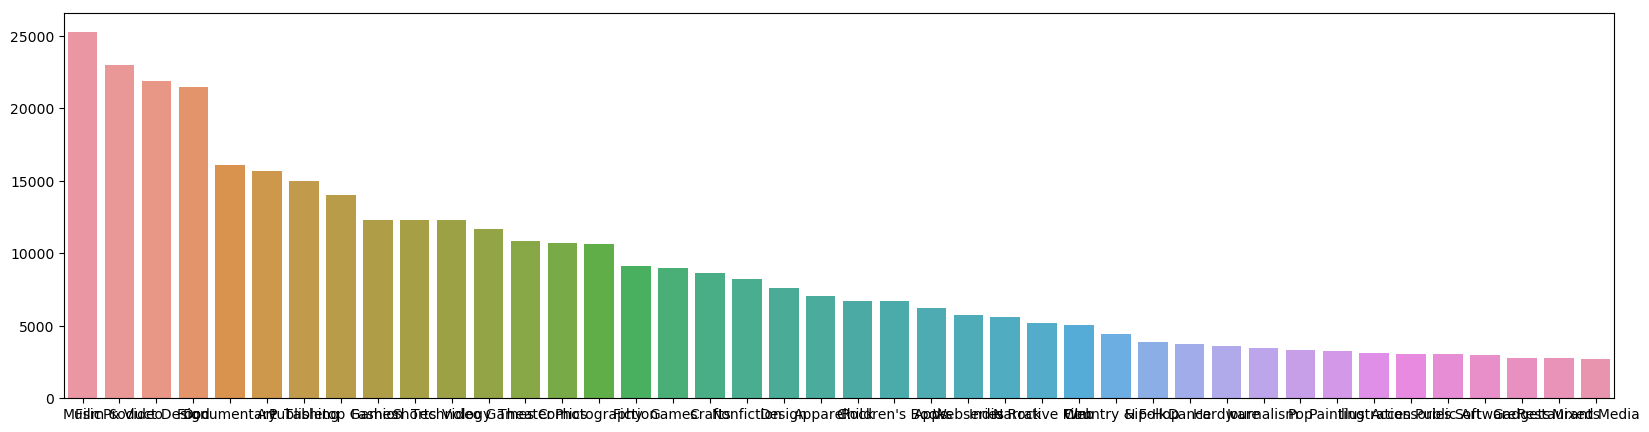

In [12]:
barplots(df['category']), df['category'].value_counts()

### Currency & Country

In [13]:
df[['currency', 'country']].value_counts()

currency  country
USD       US         289671
GBP       GB          33215
CAD       CA          14508
AUD       AU           7681
EUR       DE           4057
          FR           2873
          NL           2807
          IT           2775
          ES           2204
SEK       SE           1718
MXN       MX           1632
NZD       NZ           1425
DKK       DK           1083
EUR       IE            793
CHF       CH            736
NOK       NO            694
EUR       BE            597
          AT            576
HKD       HK            564
SGD       SG            521
USD       N,0"          166
EUR       LU             61
JPY       JP             31
EUR       N,0"           24
GBP       N,0"           24
AUD       N,0"            7
CAD       N,0"            5
DKK       N,0"            3
NOK       N,0"            2
SEK       N,0"            1
dtype: int64

In [14]:
df['currency'].value_counts()

USD    289837
GBP     33239
EUR     16767
CAD     14513
AUD      7688
SEK      1719
MXN      1632
NZD      1425
DKK      1086
CHF       736
NOK       696
HKD       564
SGD       521
JPY        31
Name: currency, dtype: int64

In [15]:
df['country'].value_counts()

US      289671
GB       33215
CA       14508
AU        7681
DE        4057
FR        2873
NL        2807
IT        2775
ES        2204
SE        1718
MX        1632
NZ        1425
DK        1083
IE         793
CH         736
NO         694
BE         597
AT         576
HK         564
SG         521
N,0"       232
LU          61
JP          31
Name: country, dtype: int64

#### まとめ
- currencyとcountryはほとんど一致していそう
- countryの方が情報量が豊富
    - currencyのみだと、EU圏内で情報を落としてしまう
- countryには欠損値が存在する

#### 前処理の方針
- 学習にはcountryカラムを用いる
- countryカラムの欠損値は、currencyの情報を用いて補完する
- currencyとcountryで情報の不一致がある時は、外れ値としてデータから除外する

#### currencyとcountryの情報の一致の確認

In [16]:
x = df.loc[(df['country']!='N,0"') & (df['currency']!='EUR'), ['country', 'currency']]
x['currency'] = x['currency'].str[:2]

(x['country'] != x['currency']).sum() # 0
# 情報の不一致は存在しない模様。

0

#### countryカラムの欠損値処理
- currencyの情報をもとに補完するつもりだったが、「欠損値であった」という情報を保存する方が予測精度が上がりそうだったので、補完は辞める。
- 前処理としては、currencyカラムを削除するのみとする。

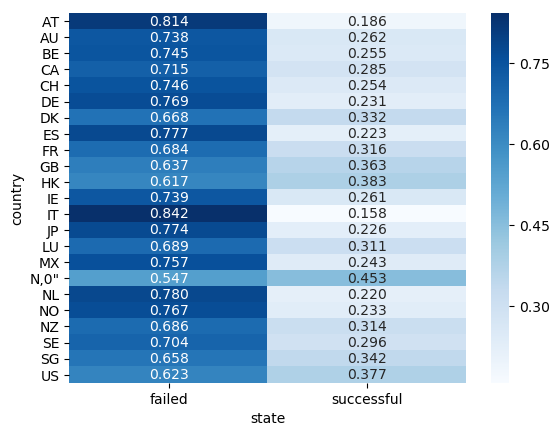

In [17]:
cross_heatmap(data=df, exp_val='country', tar_val='state')

In [18]:
df = df.drop('currency', axis=1)
df.head()

,category,main_category,deadline,launched,state,country,usd_goal_real
0,Publishing,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


### usd_goal_real

In [19]:
df.head()

,category,main_category,deadline,launched,state,country,usd_goal_real
0,Publishing,Publishing,2015-10-09,2015-08-11 12:12:28,failed,GB,1533.95
1,Narrative Film,Film & Video,2017-11-01,2017-09-02 04:43:57,failed,US,30000.00
2,Narrative Film,Film & Video,2013-02-26,2013-01-12 00:20:50,failed,US,45000.00
3,Music,Music,2012-04-16,2012-03-17 03:24:11,failed,US,5000.00
4,Film & Video,Film & Video,2015-08-29,2015-07-04 08:35:03,failed,US,19500.00


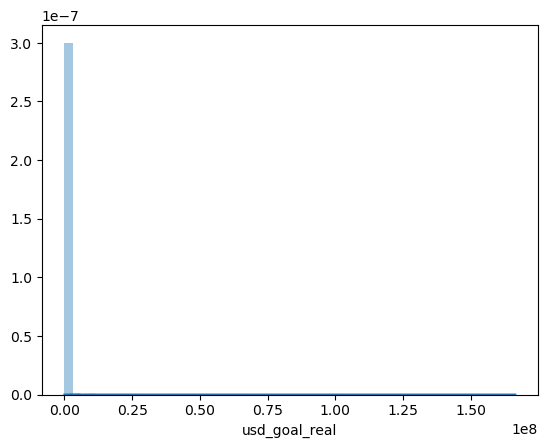

In [20]:
# check distribution
sns.distplot(df.usd_goal_real)

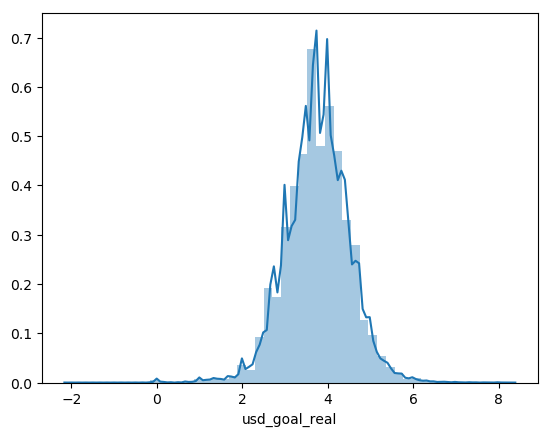

In [21]:
# 歪な分布なので、対数変換をしてみる
x = df['usd_goal_real'].map(math.log10)
sns.distplot(x)

In [22]:
# 学習には対数変換後の値を用いることとする。
df['usd_goal_real'] = df['usd_goal_real'].map(math.log10)

### deadline & launched
- launchedカラムには外れ値が存在する模様（下記boxenplot参照）→削除する
- プロジェクトの期間を表すdurationカラムを追加する。

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


distribution of deadline


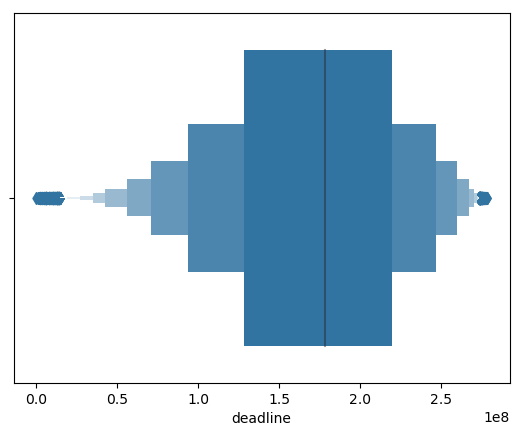

distribution of launched


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


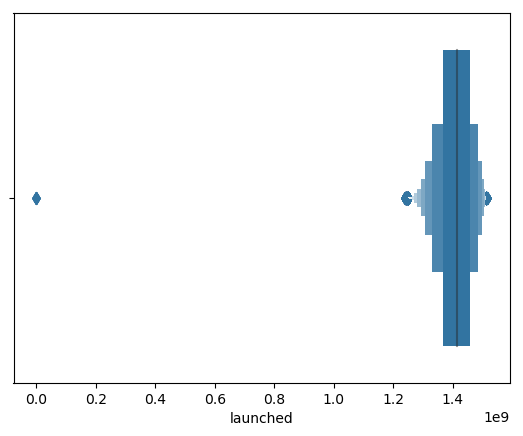

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


distribution of duration


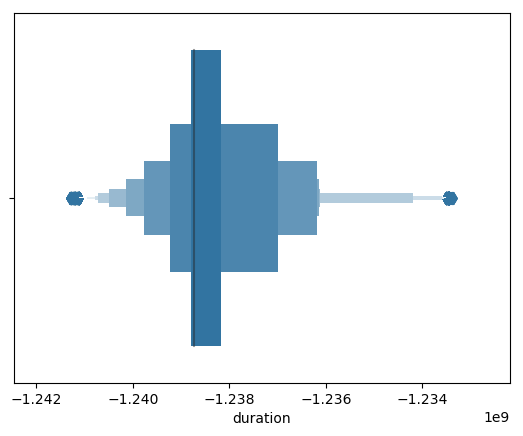

In [23]:
# make data computable
def datetime_computable(pdSeries):
    values = (pdSeries - pdSeries.min()).dt.total_seconds()
    return values

df.loc[:, ['deadline', 'launched']] = df.loc[:, ['deadline', 'launched']].apply(pd.to_datetime)
df['deadline'] = datetime_computable(df['deadline'])
df['launched'] = datetime_computable(df['launched'])

# check distribution
print('distribution of deadline')
sns.boxenplot(df.deadline)
plt.show()

print('distribution of launched')
sns.boxenplot(df.launched)
plt.show()

# exclude outliers in launced column
df = df.loc[df['launched']!=0, :]

# generate duration column
df['duration'] = df['deadline'] - df['launched']

# drop launched column
df = df.drop('launched', axis=1)

print('distribution of duration')
sns.boxenplot(df.duration)
plt.show()

### Overview of processed data

In [24]:
# keep processed data
df_processed = copy.copy(df)

display(df_processed.head())
display(df_processed.describe(include='all'))

,category,main_category,deadline,state,country,usd_goal_real,duration
0,Publishing,Publishing,203040000.0,failed,GB,3.185811,-1.236252e+09
1,Narrative Film,Film & Video,268185600.0,failed,US,4.477121,-1.236138e+09
2,Narrative Film,Film & Video,120528000.0,failed,US,4.653213,-1.237418e+09
3,Music,Music,93225600.0,failed,US,3.698970,-1.238725e+09
4,Film & Video,Film & Video,199497600.0,failed,US,4.290035,-1.236498e+09


,category,main_category,deadline,state,country,usd_goal_real,duration
count,370448,370448,3.704480e+05,370448,370448,370448.000000,3.704480e+05
unique,42,15,NaN,2,23,NaN,NaN
top,Music,Film & Video,NaN,failed,US,NaN,NaN
freq,25292,62280,NaN,236492,289665,NaN,NaN
mean,NaN,NaN,1.724521e+08,NaN,NaN,3.752728,-1.238402e+09
std,NaN,NaN,6.037490e+07,NaN,NaN,0.737953,1.105414e+06
min,NaN,NaN,0.000000e+00,NaN,NaN,-2.000000,-1.241305e+09
25%,NaN,NaN,1.281312e+08,NaN,NaN,3.301030,-1.238791e+09
50%,NaN,NaN,1.782432e+08,NaN,NaN,3.740363,-1.238741e+09
75%,NaN,NaN,2.197152e+08,NaN,NaN,4.203094,-1.238167e+09


## 説明変数と目的変数との関係性を確認

### Overview

In [25]:
df = copy.copy(df_processed)
display(df.head())
display(df.describe(include='all'))

,category,main_category,deadline,state,country,usd_goal_real,duration
0,Publishing,Publishing,203040000.0,failed,GB,3.185811,-1.236252e+09
1,Narrative Film,Film & Video,268185600.0,failed,US,4.477121,-1.236138e+09
2,Narrative Film,Film & Video,120528000.0,failed,US,4.653213,-1.237418e+09
3,Music,Music,93225600.0,failed,US,3.698970,-1.238725e+09
4,Film & Video,Film & Video,199497600.0,failed,US,4.290035,-1.236498e+09


,category,main_category,deadline,state,country,usd_goal_real,duration
count,370448,370448,3.704480e+05,370448,370448,370448.000000,3.704480e+05
unique,42,15,NaN,2,23,NaN,NaN
top,Music,Film & Video,NaN,failed,US,NaN,NaN
freq,25292,62280,NaN,236492,289665,NaN,NaN
mean,NaN,NaN,1.724521e+08,NaN,NaN,3.752728,-1.238402e+09
std,NaN,NaN,6.037490e+07,NaN,NaN,0.737953,1.105414e+06
min,NaN,NaN,0.000000e+00,NaN,NaN,-2.000000,-1.241305e+09
25%,NaN,NaN,1.281312e+08,NaN,NaN,3.301030,-1.238791e+09
50%,NaN,NaN,1.782432e+08,NaN,NaN,3.740363,-1.238741e+09
75%,NaN,NaN,2.197152e+08,NaN,NaN,4.203094,-1.238167e+09


### Categorical variables

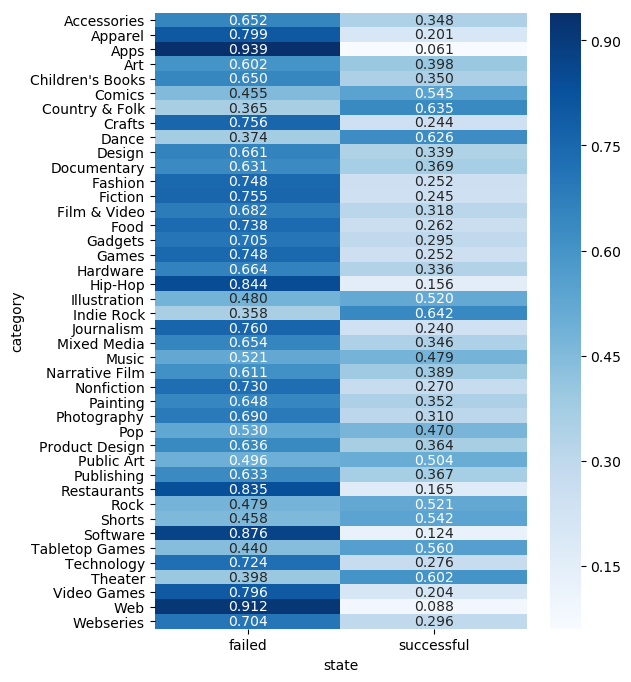

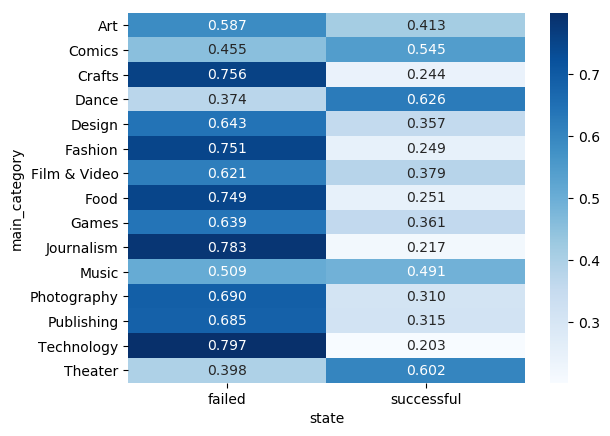

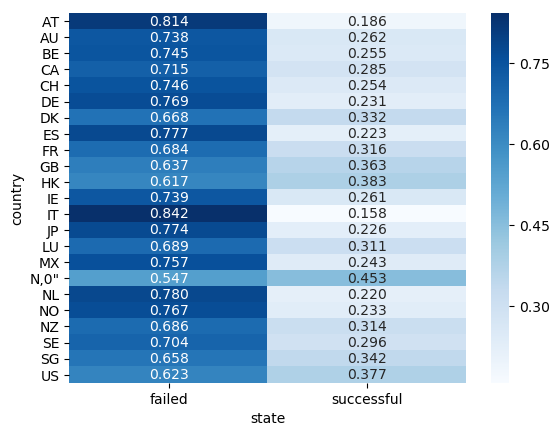

In [26]:
plt.figure(figsize=(6, 8))
cross_heatmap(data=df, tar_val='state', exp_val='category')
plt.show()

cross_heatmap(data=df, tar_val='state', exp_val='main_category')
plt.show()

cross_heatmap(data=df, tar_val='state', exp_val='country')
plt.show()


### Quantitative variables

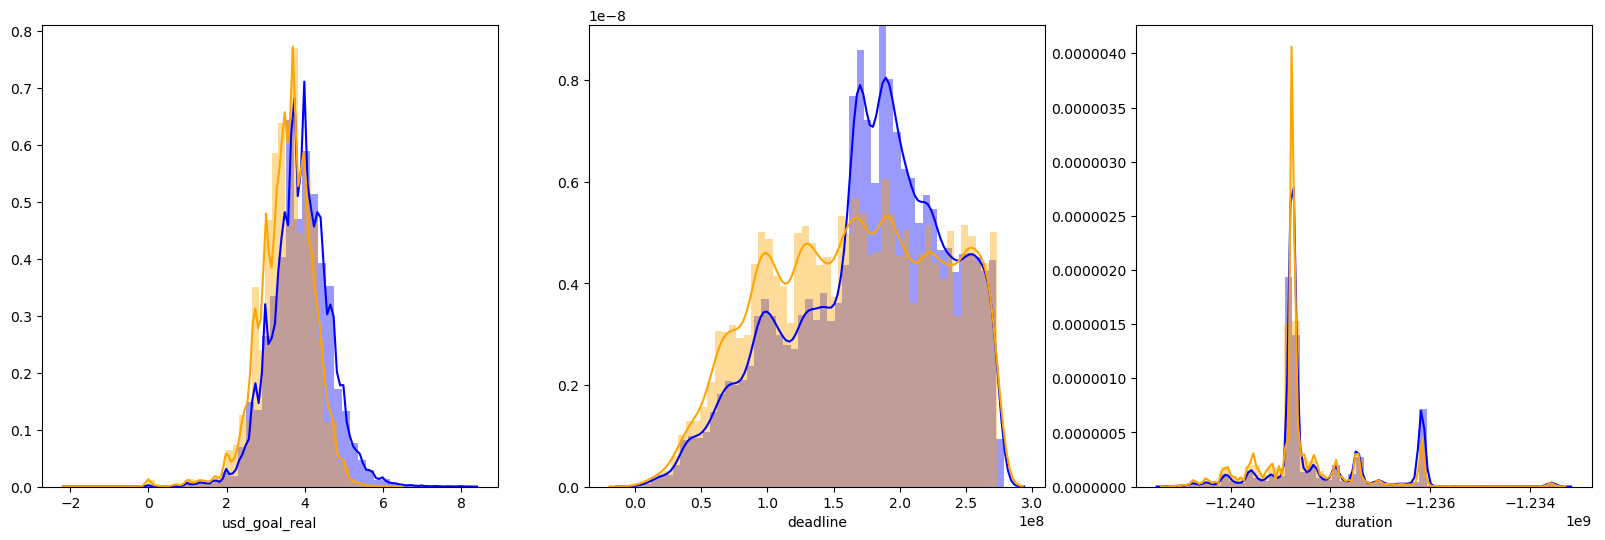

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

sns.distplot(df.loc[df['state']=='failed', 'usd_goal_real'], ax=ax[0], color='blue')
sns.distplot(df.loc[df['state']=='failed', 'deadline'], ax=ax[1], color='blue')
sns.distplot(df.loc[df['state']=='failed', 'duration'], ax=ax[2], color='blue')

sns.distplot(df.loc[df['state']=='successful', 'usd_goal_real'], ax=ax[0], color='orange')
sns.distplot(df.loc[df['state']=='successful', 'deadline'], ax=ax[1], color='orange')
sns.distplot(df.loc[df['state']=='successful', 'duration'], ax=ax[2], color='orange')

plt.show()

### Summary
- どの変数も予測に役立ちそうなので、全て学習に用いることとする。

## データの整形

1. Standardize quantitative data
    - いちいち学習前にスケーリングするのが面倒なので、ここでまとめてスケーリングしておく。
    - 理想的には、訓練データのみでスケーリングし、そのパラメータの値を用いてテストデータをスケーリングするものらしい。  

  
2. Convert dataframe to ndarray

In [28]:
df = copy.copy(df_processed)

### 1. Standardize

In [29]:
print('before standardization')
display(df.head())

quantitative = ['deadline', 'usd_goal_real', 'duration']
df_qnt = df[quantitative]

scaler = StandardScaler()
df_qnt_scaled = pd.DataFrame(scaler.fit_transform(df_qnt.values), columns=quantitative, index=df.index)

df[quantitative] = df_qnt_scaled[quantitative]

print('after standardization')
display(df.head())

before standardization


,category,main_category,deadline,state,country,usd_goal_real,duration
0,Publishing,Publishing,203040000.0,failed,GB,3.185811,-1.236252e+09
1,Narrative Film,Film & Video,268185600.0,failed,US,4.477121,-1.236138e+09
2,Narrative Film,Film & Video,120528000.0,failed,US,4.653213,-1.237418e+09
3,Music,Music,93225600.0,failed,US,3.698970,-1.238725e+09
4,Film & Video,Film & Video,199497600.0,failed,US,4.290035,-1.236498e+09


after standardization


,category,main_category,deadline,state,country,usd_goal_real,duration
0,Publishing,Publishing,0.506633,failed,GB,-0.768230,1.945373
1,Narrative Film,Film & Video,1.585653,failed,US,0.981626,2.047878
2,Narrative Film,Film & Video,-0.860029,failed,US,1.220248,0.889747
3,Music,Music,-1.312244,failed,US,-0.072848,-0.292618
4,Film & Video,Film & Video,0.447960,failed,US,0.728105,1.722691


### 2. Conversion from dataframe to ndarray

In [30]:
# convert target variable to ndarray
y = pd.get_dummies(df['state'])['successful'].values

# convert explanatory variables to ndarray
df_quantitative = df.drop('state', axis=1)[quantitative]
df_categorical = df.drop('state', axis=1).drop(quantitative, axis=1)

X1 = df_quantitative.values
X2 = pd.get_dummies(df_categorical).values
X = np.concatenate([X1, X2], axis=1)

## 共通処理用の関数定義

In [31]:
kf = KFold(n_splits=5, shuffle=True, random_state=1234)

def CV(model, X, y):
    cv_result = pd.DataFrame()

    for train_idx, test_idx in kf.split(X, y):
        X_train, X_test = X[train_idx, :], X[test_idx, :]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        cv_foldX = pd.DataFrame({'y_true':y_test, 'y_pred':y_pred})
        cv_result = pd.concat([cv_result, cv_foldX], axis=0)
        
    return cv_result

def errors_and_scores(cv_result):
    y_true = cv_result.y_true
    y_pred = cv_result.y_pred
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    # print(round(mse, 3), round(rmse, 3), round(mae, 3))

    acc = accuracy_score(y_true, y_pred)
    pre = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # print(acc, pre, rec, f1)
    
    return {
        'MSE': round(mse,3),
        'RMSE': round(rmse,3),
        'MAE': round(mae,3),
        'accuracy': round(acc,3),
        'precision': round(pre,3),
        'recall': round(rec,3),
        'f1': round(f1,3)
    }


def conf_mat(cv_result):
    conf_mat = pd.crosstab(cv_result.y_true, cv_result.y_pred, normalize='all')
    fig = plt.figure(figsize=(5, 2))
    sns.heatmap(conf_mat, annot=True, cmap='Blues')
    plt.show()

## ロジスティック回帰

### No penalty

{'MAE': 57.498,
 'MSE': 0.316,
 'RMSE': 0.562,
 'accuracy': 0.684,
 'f1': 0.463,
 'precision': 0.599,
 'recall': 0.377}


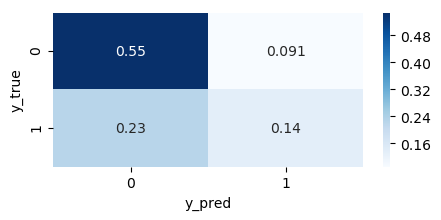

In [48]:
# 正則化なし
clf = SGDClassifier(loss='log',
                    penalty='None',
                    # l1_ratio=0.15,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)


### Lasso

{'MAE': 57.886,
 'MSE': 0.316,
 'RMSE': 0.562,
 'accuracy': 0.684,
 'f1': 0.461,
 'precision': 0.601,
 'recall': 0.373}


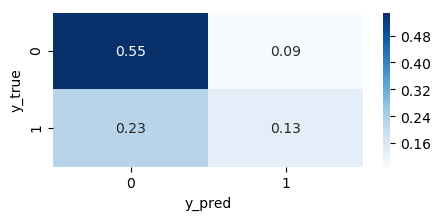

In [46]:
# ラッソ回帰
clf = SGDClassifier(loss='log',
                    penalty='l1',
                    # l1_ratio=0.15,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)

### Ridge

{'MAE': 57.745,
 'MSE': 0.316,
 'RMSE': 0.562,
 'accuracy': 0.684,
 'f1': 0.461,
 'precision': 0.6,
 'recall': 0.375}


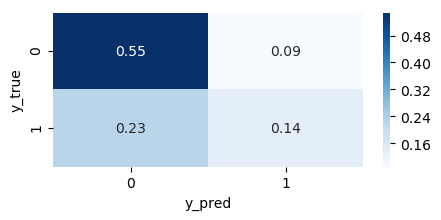

In [47]:
# リッジ回帰
clf = SGDClassifier(loss='log',
                    penalty='l2',
                    # l1_ratio=0.15,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)


### ElasticNet

{'MAE': 57.771,
 'MSE': 0.316,
 'RMSE': 0.562,
 'accuracy': 0.684,
 'f1': 0.461,
 'precision': 0.6,
 'recall': 0.374}


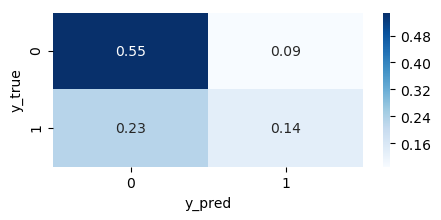

In [49]:
# ElasticNet
clf = SGDClassifier(loss='log',
                    penalty='ElasticNet',
                    l1_ratio=0.15,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)


### GridSearchによるElasticNetハイパーパラメータチューニング

In [54]:
model = SGDClassifier(loss='log',
                    penalty='ElasticNet',
                    # l1_ratio=0.15,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

parameters = {'l1_ratio': np.arange(0.1, 1, 0.2)}

clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy')
clf.fit(X, y)
clf.best_params_

{'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])}

In [57]:
parameters = {'l1_ratio': np.arange(0.05, 0.15, 0.02)}

clf = GridSearchCV(model, parameters, cv=3, scoring='accuracy')
clf.fit(X, y)
clf.best_params_

{'l1_ratio': 0.07}

{'MAE': 57.739,
 'MSE': 0.316,
 'RMSE': 0.562,
 'accuracy': 0.684,
 'f1': 0.461,
 'precision': 0.6,
 'recall': 0.375}


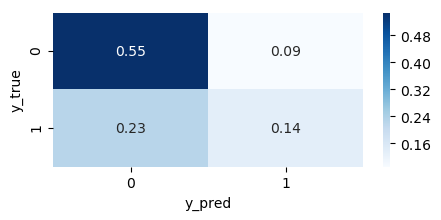

In [58]:
### ベストなパラメータを使い交差検証
clf = SGDClassifier(loss='log',
                    penalty='ElasticNet',
                    l1_ratio=0.07,
                    fit_intercept=True,
                    max_iter=1e5,
                    tol=1e-3,
                    random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)

## SVM

{'MAE': 66.753,
 'MSE': 0.332,
 'RMSE': 0.576,
 'accuracy': 0.668,
 'f1': 0.387,
 'precision': 0.598,
 'recall': 0.286}


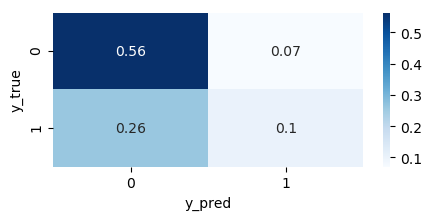

In [45]:
from sklearn.svm import SVC

clf = SVC(C=1,
          kernel='rbf',
          gamma='auto',
          tol=1e-3,
          max_iter=1e5,
          random_state=1234)

n_samples = 10000
idx = np.random.choice(np.arange(len(X)), size=n_samples)
X_svm, y_svm = X[idx,:], y[idx]

res = CV(clf, X_svm, y_svm)

pprint.pprint(errors_and_scores(res))
conf_mat(res)


# Decision Tree Classifier

{'MAE': 55.074,
 'MSE': 0.317,
 'RMSE': 0.563,
 'accuracy': 0.683,
 'f1': 0.48,
 'precision': 0.591,
 'recall': 0.404}


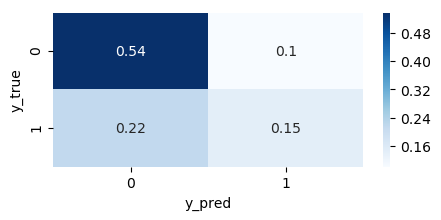

In [78]:
# まずは適当なハイパーパラメータを用いる。
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_leaf=1000,
                             min_samples_split=3,
                             random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)

In [ ]:
model = DecisionTreeClassifier(criterion='gini',
                            #  max_depth=None,
                             min_samples_leaf=1000,
                             min_samples_split=3,
                             random_state=1234)

parameters = {'max_depth': [10, 100, 1000, 10000]}
clf = GridSearchCV(model, parameters, cv=3)

clf.fit(X, y)
clf.best_params_

In [89]:
model = DecisionTreeClassifier(criterion='gini',
                            #  max_depth=None,
                             min_samples_leaf=1000,
                             min_samples_split=3,
                             random_state=1234)

parameters = {'max_depth': [50, 75, 100, 125]}
clf = GridSearchCV(model, parameters, cv=3)

clf.fit(X, y)
clf.best_params_

{'max_depth': 50}

{'MAE': 55.074,
 'MSE': 0.317,
 'RMSE': 0.563,
 'accuracy': 0.683,
 'f1': 0.48,
 'precision': 0.591,
 'recall': 0.404}


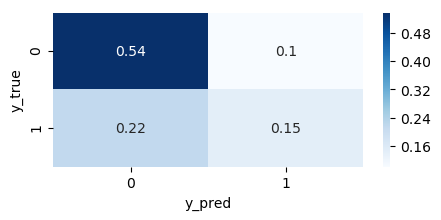

In [90]:
clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=50,
                             min_samples_leaf=1000,
                             min_samples_split=3,
                             random_state=1234)

res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)

## Random Forest

{'MAE': 73.414,
 'MSE': 0.325,
 'RMSE': 0.57,
 'accuracy': 0.675,
 'f1': 0.313,
 'precision': 0.666,
 'recall': 0.204}


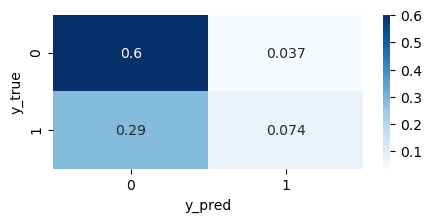

In [88]:
clf = RandomForestClassifier(n_estimators=100,
                             criterion='gini',
                             max_depth=10,
                             min_samples_leaf=1000,
                             min_samples_split=100,
                             random_state=1234)


res = CV(clf, X, y)
pprint.pprint(errors_and_scores(res))
conf_mat(res)

## AdaBoost

In [ ]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=1000,
        min_samples_split=100, 
        random_state=1234,
        ),
    
    n_estimators=100, 
    random_state=1234)

# 以下は20分経っても計算が終わらなかった。
# res = CV(clf, X, y)
# pprint.pprint(errors_and_scores(res))
# conf_mat(res)

# AdaBoostと交差検証は相性が悪いのかもしれない。
# もしくは、単にRandom Forestと比べても、直列計算であるために時間が弱学習器の数に比例して大きくなるのかもしれない
# 弱識別器の数が10だと約40秒、20だと約80秒だったので、後者の仮説が正しそう。

In [99]:
clf = AdaBoostClassifier(
    DecisionTreeClassifier(
        criterion='gini',
        max_depth=5,
        min_samples_leaf=1000,
        min_samples_split=100, 
        random_state=1234,
        ),
    
    n_estimators=50, 
    random_state=1234)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
clf.fit(X_train, y_train)

# 時間がかかるので交差検証法は行わない

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1000, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best'),
          learning_rate=1.0, n_estimators=50, random_state=1234)

{'MAE': 49.516,
 'MSE': 0.297,
 'RMSE': 0.545,
 'accuracy': 0.703,
 'f1': 0.528,
 'precision': 0.617,
 'recall': 0.461}


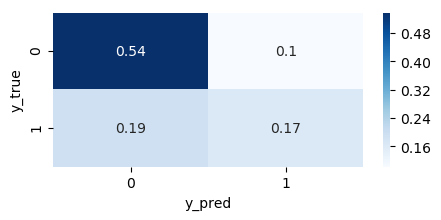

In [100]:
y_pred = clf.predict(X_test)
res = pd.DataFrame({'y_true':y_test, 'y_pred':y_pred})
pprint.pprint(errors_and_scores(res))
conf_mat(res)

## Neural Network (Archive)

In [101]:
from tensorflow import keras
import tensorflow as ts

c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\Users\masa_\anaconda3\envs\suai\lib\site-packages\tensorflow\python\frame

In [128]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(60, activation='relu', input_dim=X.shape[1]))
model.add(Dense(50, activation='relu', input_dim=57))
model.add(Dense(30, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=RMSprop(lr=0.01),
    optimizer=RMSprop(lr=0.01),
    metrics=['accuracy'])


Train on 296358 samples, validate on 74090 samples
Epoch 1/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.6113 - acc: 0.6795 - val_loss: 0.5798 - val_acc: 0.6915
Epoch 2/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5753 - acc: 0.6944 - val_loss: 0.5770 - val_acc: 0.6919
Epoch 3/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5724 - acc: 0.6961 - val_loss: 0.5757 - val_acc: 0.6923
Epoch 4/30
296358/296358 [==============================] - 1s 4us/sample - loss: 0.5709 - acc: 0.6965 - val_loss: 0.5753 - val_acc: 0.6933
Epoch 5/30
296358/296358 [==============================] - 1s 4us/sample - loss: 0.5696 - acc: 0.6979 - val_loss: 0.5734 - val_acc: 0.6936
Epoch 6/30
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5686 - acc: 0.6988 - val_loss: 0.5754 - val_acc: 0.6925
Epoch 7/30
296358/296358 [==============================] - 1s 4us/sample - loss: 0.5676 - acc: 0.6990 - val_

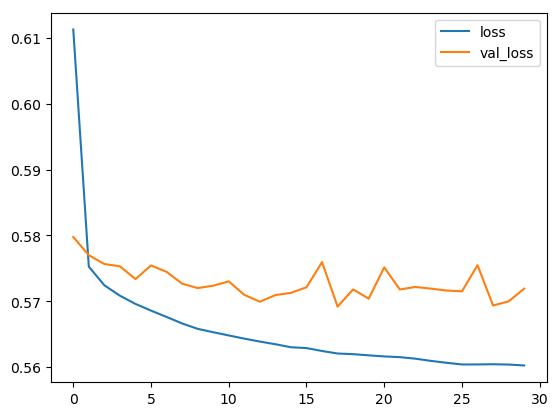

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=1024,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

In [ ]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(60, activation='relu', input_dim=X.shape[1]))
model.add(Dense(50, activation='relu', input_dim=57))
model.add(Dense(30, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
# sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=RMSprop(lr=0.01),
    optimizer=RMSprop(lr=0.01),
    metrics=['accuracy'])


Train on 296358 samples, validate on 74090 samples
Epoch 1/30
296358/296358 [==============================] - 1s 4us/sample - loss: 0.5679 - acc: 0.6979 - val_loss: 0.5782 - val_acc: 0.6924
Epoch 2/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5680 - acc: 0.6974 - val_loss: 0.5788 - val_acc: 0.6920
Epoch 3/30
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5681 - acc: 0.6976 - val_loss: 0.5778 - val_acc: 0.6923
Epoch 4/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5678 - acc: 0.6978 - val_loss: 0.5790 - val_acc: 0.6929
Epoch 5/30
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5681 - acc: 0.6975 - val_loss: 0.5783 - val_acc: 0.6923
Epoch 6/30
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5681 - acc: 0.6975 - val_loss: 0.5787 - val_acc: 0.6921
Epoch 7/30
296358/296358 [==============================] - 2s 6us/sample - loss: 0.5681 - acc: 0.6973 - val_

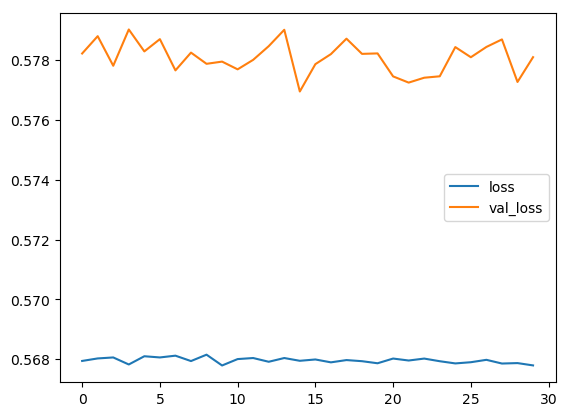

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=1024,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

Train on 296358 samples, validate on 74090 samples
Epoch 1/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6971 - val_loss: 0.5754 - val_acc: 0.6925
Epoch 2/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6971 - val_loss: 0.5754 - val_acc: 0.6927
Epoch 3/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6972 - val_loss: 0.5754 - val_acc: 0.6925
Epoch 4/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6972 - val_loss: 0.5754 - val_acc: 0.6925
Epoch 5/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6972 - val_loss: 0.5754 - val_acc: 0.6925
Epoch 6/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5687 - acc: 0.6973 - val_loss: 0.5754 - val_acc: 0.6924
Epoch 7/50
296358/296358 [==============================] - 1s 2us/sample - loss: 0.5686 - acc: 0.6973 - val_

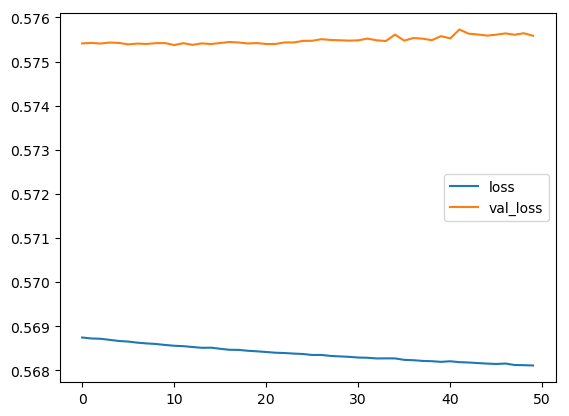

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16384,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

Train on 296358 samples, validate on 74090 samples
Epoch 1/50
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5686 - acc: 0.6974 - val_loss: 0.5756 - val_acc: 0.6930
Epoch 2/50
296358/296358 [==============================] - 1s 5us/sample - loss: 0.5685 - acc: 0.6977 - val_loss: 0.5764 - val_acc: 0.6920
Epoch 3/50
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5685 - acc: 0.6978 - val_loss: 0.5759 - val_acc: 0.6918
Epoch 4/50
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5686 - acc: 0.6976 - val_loss: 0.5761 - val_acc: 0.6929
Epoch 5/50
296358/296358 [==============================] - 2s 6us/sample - loss: 0.5685 - acc: 0.6976 - val_loss: 0.5758 - val_acc: 0.6928
Epoch 6/50
296358/296358 [==============================] - 2s 6us/sample - loss: 0.5685 - acc: 0.6975 - val_loss: 0.5761 - val_acc: 0.6913
Epoch 7/50
296358/296358 [==============================] - 2s 5us/sample - loss: 0.5684 - acc: 0.6974 - val_

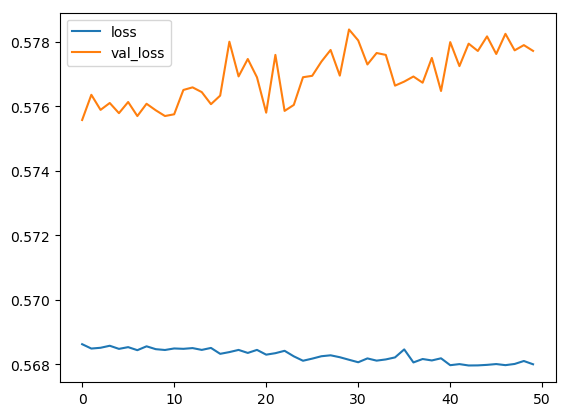

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=1024,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

Train on 296358 samples, validate on 74090 samples
Epoch 1/15
296358/296358 [==============================] - 5s 17us/sample - loss: 0.5718 - acc: 0.6958 - val_loss: 0.5744 - val_acc: 0.6934
Epoch 2/15
296358/296358 [==============================] - 5s 16us/sample - loss: 0.5714 - acc: 0.6957 - val_loss: 0.5744 - val_acc: 0.6924
Epoch 3/15
296358/296358 [==============================] - 5s 15us/sample - loss: 0.5711 - acc: 0.6968 - val_loss: 0.5750 - val_acc: 0.6923
Epoch 4/15
296358/296358 [==============================] - 6s 20us/sample - loss: 0.5710 - acc: 0.6959 - val_loss: 0.5751 - val_acc: 0.6925
Epoch 5/15
296358/296358 [==============================] - 5s 17us/sample - loss: 0.5713 - acc: 0.6953 - val_loss: 0.5752 - val_acc: 0.6928
Epoch 6/15
296358/296358 [==============================] - 4s 15us/sample - loss: 0.5713 - acc: 0.6961 - val_loss: 0.5740 - val_acc: 0.6938
Epoch 7/15
296358/296358 [==============================] - 4s 14us/sample - loss: 0.5711 - acc: 0.6962

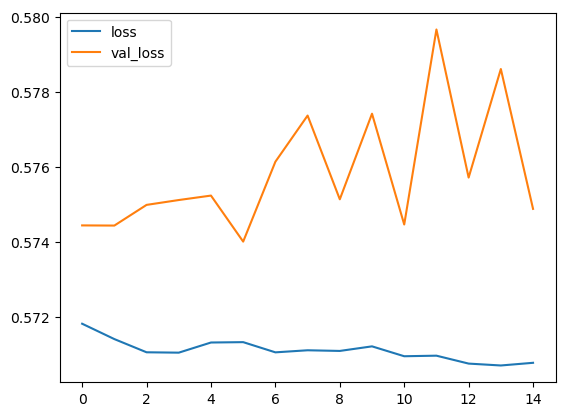

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=128,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

Train on 296358 samples, validate on 74090 samples
Epoch 1/15
296358/296358 [==============================] - 8s 27us/sample - loss: 0.5723 - acc: 0.6954 - val_loss: 0.5783 - val_acc: 0.6892
Epoch 2/15
296358/296358 [==============================] - 10s 32us/sample - loss: 0.5723 - acc: 0.6953 - val_loss: 0.5770 - val_acc: 0.6918
Epoch 3/15
296358/296358 [==============================] - 11s 38us/sample - loss: 0.5724 - acc: 0.6953 - val_loss: 0.5785 - val_acc: 0.6896
Epoch 4/15
296358/296358 [==============================] - 11s 35us/sample - loss: 0.5729 - acc: 0.6948 - val_loss: 0.5769 - val_acc: 0.6913
Epoch 5/15
296358/296358 [==============================] - 13s 45us/sample - loss: 0.5726 - acc: 0.6956 - val_loss: 0.5765 - val_acc: 0.6933
Epoch 6/15
296358/296358 [==============================] - 11s 37us/sample - loss: 0.5724 - acc: 0.6955 - val_loss: 0.5761 - val_acc: 0.6926
Epoch 7/15
296358/296358 [==============================] - 11s 38us/sample - loss: 0.5724 - acc: 

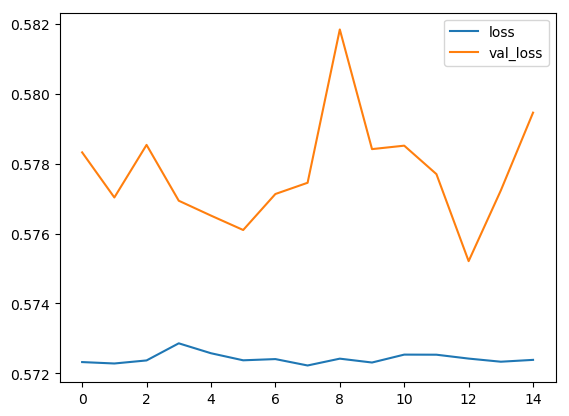

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()

Train on 296358 samples, validate on 74090 samples
Epoch 1/15
296358/296358 [==============================] - 15s 51us/sample - loss: 0.5751 - acc: 0.6939 - val_loss: 0.5783 - val_acc: 0.6912
Epoch 2/15
296358/296358 [==============================] - 13s 45us/sample - loss: 0.5744 - acc: 0.6943 - val_loss: 0.5778 - val_acc: 0.6901
Epoch 3/15
296358/296358 [==============================] - 17s 58us/sample - loss: 0.5748 - acc: 0.6944 - val_loss: 0.5772 - val_acc: 0.6902
Epoch 4/15
296358/296358 [==============================] - 14s 47us/sample - loss: 0.5748 - acc: 0.6945 - val_loss: 0.5775 - val_acc: 0.6908
Epoch 5/15
296358/296358 [==============================] - 14s 47us/sample - loss: 0.5747 - acc: 0.6939 - val_loss: 0.5808 - val_acc: 0.6909
Epoch 6/15
296358/296358 [==============================] - 11s 36us/sample - loss: 0.5747 - acc: 0.6942 - val_loss: 0.5800 - val_acc: 0.6881
Epoch 7/15
296358/296358 [==============================] - 13s 45us/sample - loss: 0.5745 - acc:

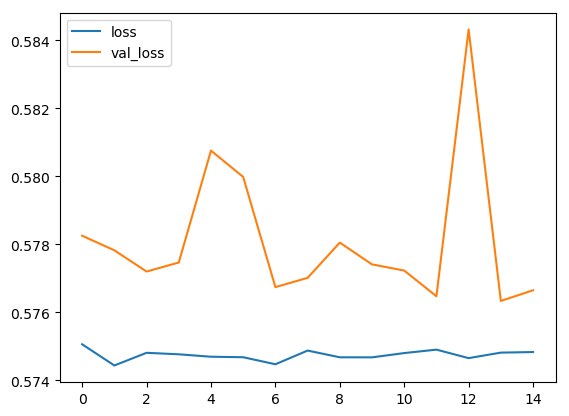

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
adm = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_test, y_test)
)

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(adm.history)

# グラフ化
df[["loss", "val_loss"]].plot()